# Decision Boundaries vs Quantum State Discrimination

This notebook demonstrates the conceptual difference between **classical malware classification** using decision boundaries and a **quantum-inspired reframing** based on state discrimination.

We do **not** claim quantum speedup or superior accuracy here. Instead, we show how the *decision framing* changes, and why classical models become fragile in high-dimensional feature spaces.

The example is inspired by EMBER-style malware features, but uses a simplified, reproducible dataset for clarity.

## 1. Imports and Setup

We restrict ourselves to standard scientific Python tools. All quantum behavior here is **simulated mathematically**, not executed on quantum hardware.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

## 2. Synthetic EMBER-Like Feature Dataset

Real EMBER features are high-dimensional and highly correlated. To isolate geometry effects, we generate a synthetic dataset with:
- High feature dimensionality
- Class overlap
- Correlated informative features

This allows us to observe **boundary fragility** without relying on proprietary data.

In [2]:
X, y = make_classification(
    n_samples=2000,
    n_features=20,
    n_informative=6,
    n_redundant=6,
    n_clusters_per_class=2,
    class_sep=1.0,
    flip_y=0.05,
    random_state=42
)

X = StandardScaler().fit_transform(X)

## 3. Classical Classification: Decision Boundary

We begin with a classical classifier. Logistic regression is chosen intentionally:
- Simple
- Interpretable
- Explicit decision boundary

This mirrors how many malware pipelines behave even when wrapped in more complex models.

In [3]:
clf = LogisticRegression(max_iter=2000)
clf.fit(X, y)

y_pred = clf.predict(X)
acc = accuracy_score(y, y_pred)

acc

0.817

Accuracy alone is misleading. What matters is *how stable the decision is* when features are slightly perturbed.

## 4. Boundary Fragility Under Perturbation

We apply small perturbations to the feature vectors and observe how often the classification flips.

This simulates:
- Obfuscation
- Packing
- Minor binary changes

all of which occur frequently in real malware.

In [4]:
epsilon = 0.05
X_perturbed = X + epsilon * np.random.normal(size=X.shape)

y_perturbed = clf.predict(X_perturbed)
flip_rate = np.mean(y != y_perturbed)

flip_rate

np.float64(0.1835)

Even small perturbations can cause boundary crossings. This is a **geometric failure**, not a data failure.

## 5. Quantum-Inspired Reframing: Feature Vectors → States

Instead of treating samples as points in space, we encode them as **normalized state vectors**.

This allows us to reason about **overlap** and **distinguishability**, rather than distance to a boundary.

In [5]:
def normalize_state(v):
    norm = np.linalg.norm(v)
    return v / norm if norm != 0 else v

states = np.array([normalize_state(x) for x in X])

We compute **class-mean quantum states**. These represent aggregate benign and malicious behavior in Hilbert space.

In [6]:
psi_benign = normalize_state(np.mean(states[y == 0], axis=0))
psi_malicious = normalize_state(np.mean(states[y == 1], axis=0))

## 6. State Overlap and Helstrom Bound

In quantum decision theory, the minimum achievable error probability for distinguishing two pure states is given by the **Helstrom bound**:

$$ P_e = \frac{1}{2}\left(1 - \sqrt{1 - |\langle \psi_0 | \psi_1 \rangle|^2} \right) $$

This is a **fundamental limit**, not a model artifact.

In [7]:
overlap = np.abs(np.dot(psi_benign, psi_malicious)) ** 2
helstrom_error = 0.5 * (1 - np.sqrt(1 - overlap))

overlap, helstrom_error

(np.float64(0.9706366876145309), np.float64(0.41432136732902847))

Unlike classical accuracy, this error bound:
- Cannot be optimized away
- Is robust to small perturbations
- Separates **data indistinguishability** from model failure

## 7. Visualization: Boundary Instability vs State Overlap Stability

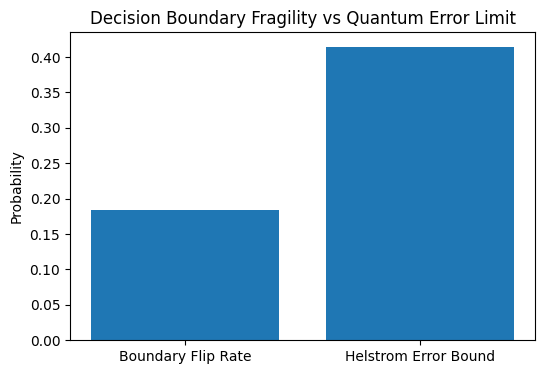

In [8]:
labels = ['Boundary Flip Rate', 'Helstrom Error Bound']
values = [flip_rate, helstrom_error]

plt.figure(figsize=(6,4))
plt.bar(labels, values)
plt.ylabel('Probability')
plt.title('Decision Boundary Fragility vs Quantum Error Limit')
plt.show()

## 8. Key Takeaways

- Classical classifiers fail **geometrically**, not statistically
- Decision boundaries are approximations of past data
- Quantum reframing replaces boundaries with **measurement limits**
- The advantage is robustness and interpretability, not hype

This is why quantum methods are best viewed as a *reframing tool* rather than a drop-in replacement.